In [1]:
#importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, label_binarize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow import get_logger
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\user\AppData\Local\Temp\ipykernel_22444\1275133151.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
seed=12345 #fijamos la semilla de aleatorización para que sea la misma en todo el proceso
#Reemplaza con la ruta correcta y nombre de tu archivo
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Documentos/Titulo Propio/Machine Learning/Redes Neuronales/Python/SAheart.csv' 
#convertir a data frame el archivo
df = pd.read_csv(file_path)

In [3]:
# Si se quiere categorizar la variable de respuesta (útil cuando tiene 1/0)
#df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 1 else 'No')
#en nuestro caso, cambiamos Si por Yes
df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 'Si' else 'No')

In [4]:
# hay valores perdidos?
df.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

In [5]:
# organiza las variables según su rol y naturaleza
# determina variable objetivo
target = "chd"
#hacer una lista con las variables input numericas
num_cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
#hacer una lista con las variables input categóricas
cat_cols = ['famhist']

In [6]:
#Convertir a dummies las categóricas
#solo hay una variable categórica, transformación fácil
df[['famhist']] = pd.get_dummies(df[['famhist']],drop_first=True)
#otra opción
cat_cols = ColumnTransformer(transformers=[ ('ohe', OneHotEncoder(drop='first'), cat_cols)], 
                                                  remainder='passthrough')


In [9]:
#Normalizar variables numericas
#Si se quisieran estandarizar, scaler=StandardScaler()
scaler = MinMaxScaler() #selecciona el transformador
X = df[num_cols] #selecciona las variables numéricas que se quieren transformar y las guarda en un nuevo dataframe
X_scale = pd.DataFrame(scaler.fit_transform(X)) #guarda el resultado de la transformación de las variables de X en X_scale
X_scale.columns = X.columns #para simplificar los nombres, asigna a las columnas de X_scale los nombres de las variables de X_num
df[num_cols] = X_scale

# Redes Neuronales
- keras.callbacks.EarlyStopping: función utilizada durante el entrenamiento de redes neuronales para detener el entrenamiento si ciertas condiciones se cumplen. Es útil para evitar el sobreajuste y ahorrar tiempo y recursos de cuando se ha alcanzado un punto óptimo en el entrenamiento. EarlyStopping tiene muchos parámetros que se pueden tener en cuenta Durante el entrenamiento, supervisa una métrica de validación específica. Si esta métrica no mejora después de un cierto número de épocas (epocs), se detiene el entrenamiento. Se puede especificar un valor para indicar qué métrica de validación se debe monitorear (por ejemplo, 'val_loss' para la pérdida en el conjunto de validación o 'val_accuracy' para la precisión en el conjunto de validación). Se puede configurar min_delta para especificar la cantidad mínima de mejora que se debe observar en la métrica para que no se detenga el entrenamiento inmediatamente. También se puede configurar mode para especificar si se debe buscar un aumento ('max') o una disminución ('min') en la métrica de validación. Además, puedes configurar restore_best_weights para restaurar los pesos del modelo al mejor estado durante el entrenamiento antes de detenerlo. Esto es útil si deseas utilizar el modelo con los mejores resultados después de la parada temprana.
- la forma más típica de construir redes en Python es con la librería Keras y usando un modelo Sequential() al que se van añadiendo capas usando la sentencia modelo.add, especificando si las capas son densamente conectadas, número de nodos, y función de activación
- Antes de entrenar un modelo de red es IMPRESCINDIBLE COMPILARLO model.compile, especificando la función de pérdida, el optimizador usado y las métricas que se usarán para su evaluación
- Una vez compilado el modelo, se entrena, model.fit, sobre los datos de entrenamiento,especificando el número de epoch (relacionado con el número de iteraciones, hiperparámetro que se ajusta antes de comenzar el entrenamiento y determina cuántas veces se repetirá el proceso de ajuste de pesos, valor típico epoch=100) y batch_size (para ganar velocidad, en vez de utilizar todos los datos de entrenamiento en cada ajuste de pesos de la red, se puede usar este hiperparámetro, que se refiere a la cantidad de ejemplos de datos de entrenamiento que se utilizan en cada paso de actualización de los pesos durante el entrenamiento, por defecto batch_size=32)
- para evaluar el rendimiento podemos usar model.evaluate(X_prueba, y_prueba)
- para hacer predicciones, podemos usar model.predict(dato nuevo)
- en este módulo usaremos redes densamente conectadas (Dense), en las que cada neurona en una capa se conecta con todas las neuronas en la capa siguiente. En este tipo de red, la información fluye en una sola dirección, desde la capa de entrada a través de capas ocultas (1) hasta la de salida 
- units se utiliza para especificar el número de neuronas o unidades en una capa dada de una red neuronal.
    En una capa oculta, el valor de units indica los nodos ocultos.
    En una capa de salida, units generalmente corresponde al número de clases o valores a los que se está tratando de predecir (1 en clasificación binaria/regresión)
- OJO: en la capa de entrada, units=input_dim, número de variables input (contando las dummies, si corresponde). Si se ha definido el conjunto de variables de entrada, una forma de hacerse puede ser units = input.shape[1]
- activation nos indica cómo modificar la función de activación
- la función de combinación no se puede cambiar como hiperparámetro, se podría definir una capa especial para ello

## Parámetros de la funcion compile()
- loss (función de pérdida): se utiliza para medir la diferencia entre las predicciones del modelo y los valores reales en el conjunto de entrenamiento. En problemas de clasificación binaria,'binary_crossentropy' y 'mean_squared_error' (error cuadrático medio). En problemas de regresión se puede usar mean_squared_error y mean_absolute_error. Se pueden definir funciones de pérdida personalizadas.
- optimizer (optimizador): se encarga de ajustar los pesos del modelo durante el entrenamiento para minimizar la función de pérdida. Es responsable de la actualización de los parámetros del modelo en función del gradiente de la función de pérdida. Los valores comunes para optimizer son 'adam', 'sgd' (descenso de gradiente estocástico) o 'rmsprop'. Se puede personalizar
- metrics (métricas): se utilizan para evaluar el rendimiento del modelo durante y después del entrenamiento. Estas métricas no influyen en la optimización del modelo. Algunas opciones para clasificación son 'accuracy', 'precision', 'recall', 'f1_score', etc., y para regresión 'mean_squared_error', 'mean_absolute_error' o 'r2'.

In [10]:
X_input = df[['age','tobacco']]
y = df['chd']
#Usamos un conversor de etiquetas
# Convierte las etiquetas "Si" y "No" a 1 y 0, respectivamente
y_numeric = (y == 'Yes').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_input, y_numeric, test_size=0.2, random_state=seed)

# ES IMPORTANTE QUE LA DISTRIBUCIÓN DE LAS CLASES SEA 'SIMILAR' EN TRAIN Y TEST.
print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')

La frecuencia de cada clase en train es: 
0    0.661247
1    0.338753
Name: chd, dtype: float64

La frecuencia de cada clase en test es: 
0    0.623656
1    0.376344
Name: chd, dtype: float64


In [11]:
model = Sequential()

#supongamos que usamos como input todas las variables numéricas que hay en X_num
#Definimos el modelo
#La capa de entrada no se especifica explícitamente en Keras porque se infiere automáticamente 
#a partir de la primera capa oculta que tiene la opción input_dim
# Capa de entrada
model.add(Dense(units=7, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida (clasificación binaria)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
# Entrenar el modelo
model.fit(X_train, y_train)
# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int) #se puede cambiar el valor a partir del cual se considera 1
accuracy = accuracy_score(y_test, y_pred_classes)
print('El accuracy calculado en test es')
print(accuracy)

3/3 [==============================] - 0s 1ms/step
El accuracy calculado en test es
0.6236559139784946


AUC calculado en test 0.5704433497536946


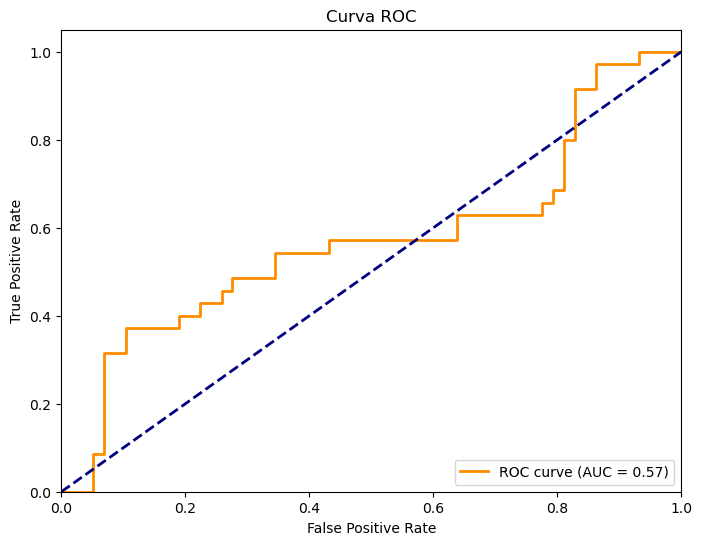

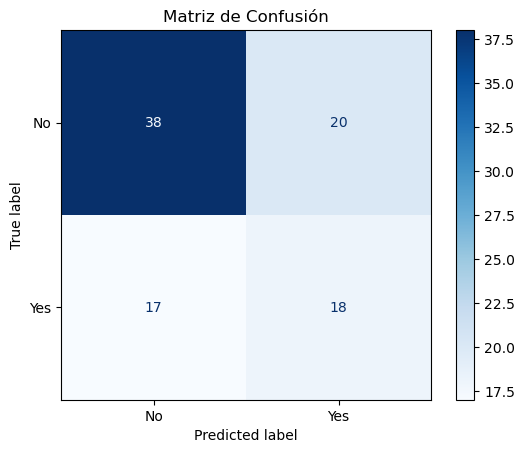

In [50]:
# Calcula las tasas de TPR y FPR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcula el AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC calculado en test', auc)

# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
#en este ejemplo casi trivial, por la división que hemos hecho, no hay dato nuevo para 

# Calcular la matriz de confusión
#OJO como el resultado proporcionado por el modelo Sequential() es en términos de probabilidades, no podemos aplicar directamente
#ConfusionMatrixDisplay, que espera etiquetas binarias
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()